## Water Potability Machine Learning Final Classifiers and Analysis

### Imports

In [1]:
import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

import pandas as pd

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.feature_selection import SelectFromModel

from sklearn.inspection import permutation_importance

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

import joblib
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

### Load Data

In [2]:
water_potability_data = pd.read_csv('../data/waterpotability.csv')
water_potability_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


### Clean Data

In [3]:
water_potability_cleaned_data = water_potability_data.copy()
water_potability_cleaned_data['ph'] = water_potability_cleaned_data['ph'].fillna(water_potability_cleaned_data['ph'].mean())
water_potability_cleaned_data['Sulfate'] = water_potability_cleaned_data['Sulfate'].fillna(water_potability_cleaned_data['Sulfate'].mean())
water_potability_cleaned_data['Trihalomethanes'] = water_potability_cleaned_data['Trihalomethanes'].fillna(water_potability_cleaned_data['Trihalomethanes'].mean())

### Data Prep

In [4]:
X = water_potability_cleaned_data.drop('Potability', axis=1)
y = water_potability_cleaned_data['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=142, shuffle=True, stratify=y)

### Handling Data Imbalance Helpers

In [5]:
# random undersampling
def undersample(X, y):
    rus = RandomUnderSampler(random_state=42)
    X_undersampled, y_undersampled = rus.fit_resample(X, y)
    return X_undersampled, y_undersampled

# random oversampling
def oversample(X, y):
    ros = RandomOverSampler(random_state=42)
    X_oversampled, y_oversampled = ros.fit_resample(X, y)
    return X_oversampled, y_oversampled

# smote
def smote(X, y):
    smote = SMOTE(random_state=42)
    X_smoted, y_smoted = smote.fit_resample(X, y)
    return X_smoted, y_smoted

### Classifier Helper Methods

In [6]:
# get scorer
def get_scorer(scorer='none'):
    if scorer == 'accuracy':
        return make_scorer(accuracy_score)
    elif scorer == 'precision':
        return make_scorer(precision_score, pos_label=1)
    elif scorer == 'recall':
        return make_scorer(recall_score, pos_label=1)
    elif scorer == 'f1':
        return make_scorer(f1_score, pos_label=1)
    elif scorer == 'roc_auc':
        return make_scorer(roc_auc_score)
    else:
        return make_scorer(accuracy_score)

In [7]:
# get classifier prefix
def get_classifier_prefix(classifier):
    if classifier == 'Logistic Regression':
        return 'lgr'
    elif classifier == 'KNN':
        return 'knn'
    elif classifier == 'SVM':
        return 'svm'
    elif classifier == 'Decision Tree':
        return 'dt'
    elif classifier == 'Random Forest':
        return 'rf'
    else:
        return 'none'

In [8]:
# sample
def sample(X_train, y_train, sampling_method='none'):
    if sampling_method == 'under':
        return undersample(X_train, y_train)
    elif sampling_method == 'over':
        return oversample(X_train, y_train)
    elif sampling_method == 'smote':
        return smote(X_train, y_train)
    else:
        return X_train, y_train

In [9]:
# get model pipeline methods

def get_classifier_pipeline(classifier):
    if classifier == 'Logistic Regression':
        return get_lgr_pipeline()
    elif classifier == 'KNN':
        return get_knn_pipeline()
    elif classifier == 'SVM':
        return get_svm_pipeline()
    elif classifier == 'Decision Tree':
        return get_dt_pipeline()
    elif classifier == 'Random Forest':
        return get_rf_pipeline()
    else:
        return None

def get_lgr_pipeline():
    extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear', random_state = 42))
    return Pipeline([('scaler', StandardScaler()),
                    ('selector', extractor),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])

def get_knn_pipeline():
    return Pipeline([('scaler', StandardScaler()),
                    ('knn', KNeighborsClassifier())])

def get_svm_pipeline():
    return Pipeline([('scaler', StandardScaler()),
                    ('svm', SVC(probability=False))])

def get_dt_pipeline():
    return Pipeline([('dt', DecisionTreeClassifier(random_state=42))])

def get_rf_pipeline():
    return Pipeline([('scaler', StandardScaler()),
                    ('rf', RandomForestClassifier(random_state=42))])

In [10]:
# get hyperparameters

def get_hyperparameters(classifier):
    if classifier == 'Logistic Regression':
        return get_lgr_hyperparameters()
    elif classifier == 'KNN':
        return get_knn_hyperparameters()
    elif classifier == 'SVM':
        return get_svm_hyperparameters()
    elif classifier == 'Decision Tree':
        return get_dt_hyperparameters()
    elif classifier == 'Random Forest':
        return get_rf_hyperparameters()
    else:
        return None

def get_lgr_hyperparameters():
    return { 
        'lgr__C': [0.001, 0.01, 0.1, 1, 10, 100] 
    }

def get_knn_hyperparameters():
    return {
        'knn__n_neighbors': [n for n in range(1,22,2)],
        'knn__weights': ['uniform', 'distance']
    }

def get_svm_hyperparameters():
    return {
        'svm__C': [0.1, 1, 10],
        'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'svm__gamma': [0.1, 1.0, 10.0]
    }

def get_dt_hyperparameters():
    return {
        'dt__max_depth': range(1,11,2),
        'dt__min_samples_split': [2,3,4,5],
        'dt__min_samples_leaf': [1,2,3,4,5],
        'dt__criterion': ['gini', 'entropy']
    }

def get_rf_hyperparameters():
    return {
        'rf__n_estimators': [100, 150, 200, 300],
        'rf__max_depth': [10, 20, 30],
        'rf__min_samples_split': [2,5,10],
        'rf__min_samples_leaf': [1,2,4],
        'rf__criterion': ['gini', 'entropy']
    }

In [11]:
def execute_classifier(classifier, X_train, y_train, X_test, y_test, scorer, sampling_method, halving_search=False):
    gs = None
    gs_path = '../models/' + get_classifier_prefix(classifier) + '_gs_' + sampling_method + '_' + scorer + '_' + '.pkl'

    if os.path.exists(gs_path):
        gs = joblib.load(gs_path)
    else:
        X_train_sampled, y_train_sampled = sample(X_train, y_train, sampling_method)
        scorer = get_scorer(scorer)

        pipe = get_classifier_pipeline(classifier)
        params = get_hyperparameters(classifier)

        if halving_search:
            gs = HalvingGridSearchCV(pipe, param_grid=params, cv=5, scoring=scorer, n_jobs=5)
        else:
            gs = GridSearchCV(pipe, param_grid=params, cv=5, scoring=scorer, n_jobs=5)

        gs.fit(X_train_sampled, y_train_sampled)
        joblib.dump(gs, gs_path)

    train_score = gs.best_score_
    test_score = gs.score(X_test, y_test)

    accuracy = accuracy_score(y_test, gs.predict(X_test))
    precision = precision_score(y_test, gs.predict(X_test))
    recall = recall_score(y_test, gs.predict(X_test))
    f1 = f1_score(y_test, gs.predict(X_test))
    roc_auc = roc_auc_score(y_test, gs.predict(X_test))

    best_params = gs.best_params_

    return train_score, test_score, accuracy, precision, recall, f1, roc_auc, best_params

In [12]:
# update the results dict with the classifier results
def update_results(results, classifier, sampling, scorer, train_score, test_score, accuracy, precision, recall, f1, roc_auc, best_params):
    results['model'].append(classifier)
    results['sampling'].append(sampling)
    results['scorer'].append(scorer)
    results['train_score'].append(train_score)
    results['test_score'].append(test_score)
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1'].append(f1)
    results['roc_auc'].append(roc_auc)
    results['best_params'].append(best_params)

### Execute Classifiers

In [13]:
classifiers = ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'Random Forest']
samplings = ['none', 'under', 'over', 'smote']
scorers = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
useHalvingSearch = ['SVM']

results = {'model': [], 'sampling': [], 'scorer': [], 'train_score': [], 'test_score': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'best_params': []}

total_iterations = len(classifiers) * len(samplings) * len(scorers)

with tqdm(total=total_iterations) as progress_bar:
    for classifier in classifiers:
        for sampling in samplings:
            for scorer in scorers:
                progress_bar.set_description(f'Executing {classifier} with {sampling} sampling and {scorer} scorer')
                halvingSearch = classifier in useHalvingSearch
                train_score, test_score, accuracy, precision, recall, f1, roc_auc, best_params = execute_classifier(classifier, X_train, y_train, X_test, y_test, scorer, sampling, halvingSearch)
                update_results(results, classifier, sampling, scorer, train_score, test_score, accuracy, precision, recall, f1, roc_auc, best_params)
                progress_bar.update(1)

    progress_bar.set_description('Classifier Executions completed')

progress_bar.close()

results_df = pd.DataFrame(results)

Classifier Executions completed: 100%|██████████| 100/100 [00:10<00:00,  9.33it/s]                                      


### Display Scores of All the Models

In [14]:
sorted_results_df = results_df.sort_values(by=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], ascending=False)
display(sorted_results_df)


,model,sampling,scorer,train_score,test_score,accuracy,precision,recall,f1,roc_auc,best_params
60,SVM,none,accuracy,0.679541,0.658537,0.658537,0.686047,0.230469,0.345029,0.581484,"{'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}"
90,Random Forest,over,accuracy,0.791320,0.658537,0.658537,0.605263,0.359375,0.450980,0.604688,"{'rf__criterion': 'entropy', 'rf__max_depth': 30, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}"
94,Random Forest,over,roc_auc,0.791221,0.604688,0.658537,0.605263,0.359375,0.450980,0.604688,"{'rf__criterion': 'entropy', 'rf__max_depth': 30, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}"
80,Random Forest,none,accuracy,0.680534,0.653963,0.653963,0.623932,0.285156,0.391421,0.587578,"{'rf__criterion': 'gini', 'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}"
62,SVM,none,recall,0.413356,0.328125,0.650915,0.595745,0.328125,0.423174,0.592812,"{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}"
63,SVM,none,f1,0.494267,0.423174,0.650915,0.595745,0.328125,0.423174,0.592812,"{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}"
92,Random Forest,over,recall,0.793344,0.402344,0.650915,0.575419,0.402344,0.473563,0.606172,"{'rf__criterion': 'gini', 'rf__max_depth': 20, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}"
86,Random Forest,under,precision,0.655839,0.557522,0.649390,0.557522,0.492188,0.522822,0.621094,"{'rf__criterion': 'entropy', 'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}"
21,KNN,none,precision,0.624408,0.633333,0.646341,0.633333,0.222656,0.329480,0.570078,"{'knn__n_neighbors': 21, 'knn__weights': 'distance'}"
91,Random Forest,over,precision,0.797093,0.572327,0.644817,0.572327,0.355469,0.438554,0.592734,"{'rf__criterion': 'gini', 'rf__max_depth': 30, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}"


### Display the Top 5 Models with the highest scores

In [15]:
top_5_results_df = sorted_results_df.head(5)
top_5_results_df

,model,sampling,scorer,train_score,test_score,accuracy,precision,recall,f1,roc_auc,best_params
60,SVM,none,accuracy,0.679541,0.658537,0.658537,0.686047,0.230469,0.345029,0.581484,"{'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}"
90,Random Forest,over,accuracy,0.791320,0.658537,0.658537,0.605263,0.359375,0.450980,0.604688,"{'rf__criterion': 'entropy', 'rf__max_depth': 30, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}"
94,Random Forest,over,roc_auc,0.791221,0.604688,0.658537,0.605263,0.359375,0.450980,0.604688,"{'rf__criterion': 'entropy', 'rf__max_depth': 30, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}"
80,Random Forest,none,accuracy,0.680534,0.653963,0.653963,0.623932,0.285156,0.391421,0.587578,"{'rf__criterion': 'gini', 'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}"
62,SVM,none,recall,0.413356,0.328125,0.650915,0.595745,0.328125,0.423174,0.592812,"{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}"


The best two performining models were:

1. SVM with no sampling trained on accuracy
    - accuracy: 0.659
    - precision: 0.686
    - roc_auc: 0.581
2. Random Forest with oversampling trained on accuracy
    - accuracy: 0.659
    - precision: 0.605
    - roc_auc: 0.605

### Display Best Models of each Classifier Type

In [16]:
best_models_df = sorted_results_df.groupby('model').first().reset_index()
best_models_df

,model,sampling,scorer,train_score,test_score,accuracy,precision,recall,f1,roc_auc,best_params
0,Decision Tree,none,recall,0.324754,0.199219,0.618902,0.531250,0.199219,0.289773,0.543359,"{'dt__criterion': 'gini', 'dt__max_depth': 9, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}"
1,KNN,none,precision,0.624408,0.633333,0.646341,0.633333,0.222656,0.329480,0.570078,"{'knn__n_neighbors': 21, 'knn__weights': 'distance'}"
2,Logistic Regression,none,accuracy,0.611832,0.612805,0.612805,1.000000,0.007812,0.015504,0.503906,{'lgr__C': 0.1}
3,Random Forest,over,accuracy,0.791320,0.658537,0.658537,0.605263,0.359375,0.450980,0.604688,"{'rf__criterion': 'entropy', 'rf__max_depth': 30, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}"
4,SVM,none,accuracy,0.679541,0.658537,0.658537,0.686047,0.230469,0.345029,0.581484,"{'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}"


### Feature Importance

In [17]:
# get the feature names

feature_names = X.columns

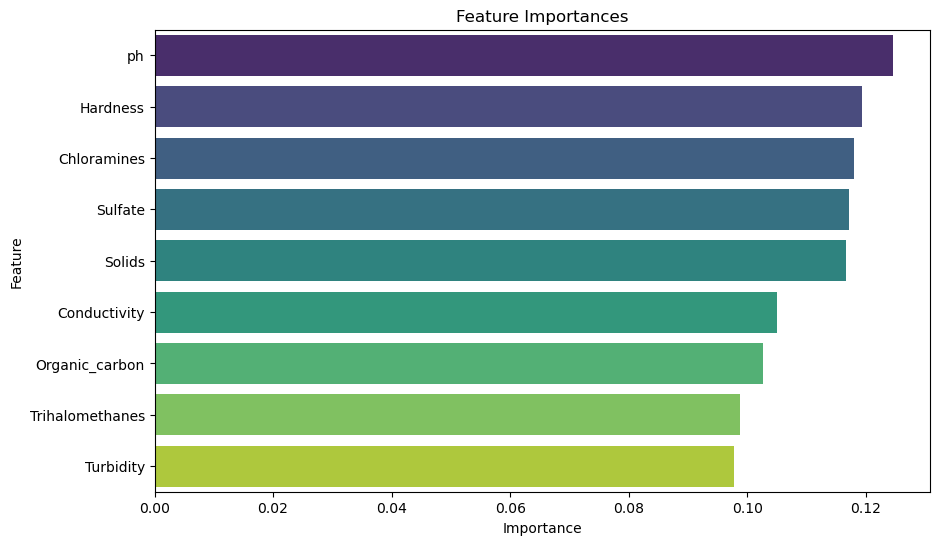

In [18]:
# feature importance of the best random forest model

rf_gs = joblib.load('../models/rf_gs_over_accuracy_.pkl')
rf_feature_importance = rf_gs.best_estimator_.named_steps['rf'].feature_importances_

rf_feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': rf_feature_importance})
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=rf_feature_importance_df, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

All the features are equally important for the best Random Forest classifier. 

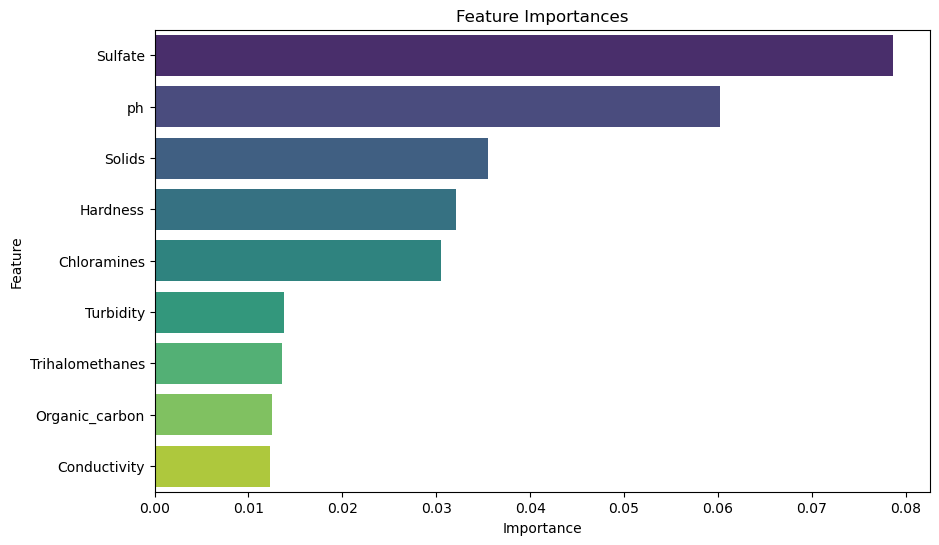

In [19]:
# feature importance of the best SVM model

svm_gs = joblib.load('../models/svm_gs_none_accuracy_.pkl')
svm_perm_importance = permutation_importance(svm_gs.best_estimator_, X, y, n_repeats=10, random_state=42)
svm_feature_importance = svm_perm_importance.importances_mean

svm_feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': svm_feature_importance})
svm_feature_importance_df = svm_feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=svm_feature_importance_df, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Sulfate and PH are the most important features for the best SVM classifier. 